# Analysis procedure for Blood Pressure Analysis

## Setting up Julia Jupyter Kernel

To use Julia on Jupyter Notebook, the package IJulia is needed. Install IJulia from the Julia REPL by pressing ] to enter pkg mode and entering:

```julia
(@v1.5) pkg> add IJulia
```
then
```julia
(@v1.5) pkg> build IJulia
```

Then the Julia kernel will be available on your Jupyter Notebook. 

## Package Installation

The following are the packages used in our analysis:
- Registered packages: CSV, DataFrames, StatsBase, DataStructures, Statistics, Plots, Ipopt, KNITRO (license needed)
- Unregistered packages: SnpArrays, VCFTools, BGEN, WiSER (private), vGWAS (private)

Registered packages can also be installed in the pkg mode of Julia REPL. 
```julia
(@v1.5) pkg> add CSV DataFrames StatsBase DataStructures Statistics Plots Ipopt
```

The vGWAS is the main analysis package. It depends on four other unregistered packages SnpArrays.jl, VCFTools.jl, BGEN.jl, and WiSER.jl. The package has not yet been registered and must be installed using the repository location. Start julia and use the ] key to switch to the package manager REPL and run:

```julia
(@v1.5) pkg> add https://github.com/OpenMendel/SnpArrays.jl
(@v1.5) pkg> add https://github.com/OpenMendel/VCFTools.jl
(@v1.5) pkg> add https://github.com/OpenMendel/BGEN.jl
(@v1.5) pkg> add https://github.com/OpenMendel/WiSER.jl
(@v1.5) pkg> add https://github.com/OpenMendel/vGWAS.jl
```

## Environment setup

The [environment](https://pkgdocs.julialang.org/v1.5/environments/) is defined by `Project.toml` and `Manifest.toml` files located in a certain directory. This is a tool to keep package versions consistent throughout different machines/users. You can copy `Project.toml` and `Manifest.toml` in this directory to your project directory, activate the environment, and instantiate it. KNITRO is not included in this project. In Pkg mode of Julia REPL:

```julia
(@v1.5) pkg> activate PROJECTDIR
(@v1.5) pkg> instantiate
```
where `PROJECTDIR` is the directory in which `Project.toml` and `Manifest.toml` exist. It can be `.` for the current working directory. You will need to run `instantiate` immediately after copying the toml files to your project directory. You will not need to run it thereafter. 
You might want to precompile the packages, especially before running the jobs on a cluster:
```julia
(@v1.5) pkg> precompile
```


In some cases, we might want to update the vGWAS package and possibly others (BGEN package in particular) during the experiment runs. In that case, we will update the toml files in this directory and notify you. Then you will need to copy the updated toml files to your directory then run `instantiate` again in the Pkg mode after activating the environment.



We can also activate environments by running 

In [1]:
using Pkg
pkg"activate ."

 Activating environment at `~/vgwas_ukb/bp/Project.toml`


on Jupyter Notebooks. Running `pkg"..."` after running `using Pkg` is equivalent to running the command `...` on the Pkg mode of REPL.

When running Julia from the command line, you can set up the environment using the command line argument, e.g., 
```sh
julia --project=. test.jl
```

## Reading data files and filtering

In [2]:
using CSV, DataFrames, Statistics, StatsBase
datadir = "../data/"; # the location where the data files from vGWAS/datasets/UKBclean of Box are stored 

Start with EUR data: 337,138 subjects.

In [3]:
phenotype_info = CSV.read(datadir * "/EUR.txt", DataFrame)
data_center = CSV.read(datadir * "/assessment_center.csv", DataFrame)
phenotype_info = leftjoin(phenotype_info, data_center, on=[:FID=>:FID], makeunique=true)

,FID,IID,AcIsch,MI,PCI,Angina_unstable,Stroke_infarct,Stroke_hem
,Int64,Int64,String,String,String,String,String,String
1,1000012,1000012,0,0,0,0,0,0
2,1000031,1000031,0,0,0,0,0,0
3,1000047,1000047,0,0,0,0,0,0
4,1000073,1000073,0,0,0,0,0,0
5,1000085,1000085,0,0,0,0,0,0
6,1000094,1000094,0,0,0,0,0,0
7,1000101,1000101,0,0,0,0,0,0
8,1000119,1000119,0,0,0,0,0,0
9,1000122,1000122,0,0,0,0,0,0


## Filtering out samples with missing covariates

Filtering out subjects with missing covariates we need: `SEX`, `age_2010`, `PC1`, `BMI`, `self_bpdrugs`. 

Sex. No missing there. 

1 is for male, 2 is for female (Plink standard)

In [4]:
using StatsBase

In [5]:
counts(phenotype_info.SEX)

2-element Array{Int64,1}:
 156111
 181027

Age at year 2010. This is later used for age at measurement (age_2010 + year_of_measurement - 2010). No missing again. 

In [6]:
count(isnan.(phenotype_info.age_2010))

0

PC1. no missing again. 

In [7]:
count(isnan.(phenotype_info.PC1))

0

BMI. Some missing exists. Filtered out 337,138 - 336,118 = 1,020 samples. 

In [8]:
phenotype_info.BMI = map(x -> x == "NA" ? missing : parse(Float64, x), phenotype_info.BMI)
phenotype_info = filter(x -> x.BMI !== missing, phenotype_info)

,FID,IID,AcIsch,MI,PCI,Angina_unstable,Stroke_infarct,Stroke_hem
,Int64,Int64,String,String,String,String,String,String
1,1000012,1000012,0,0,0,0,0,0
2,1000031,1000031,0,0,0,0,0,0
3,1000047,1000047,0,0,0,0,0,0
4,1000073,1000073,0,0,0,0,0,0
5,1000085,1000085,0,0,0,0,0,0
6,1000094,1000094,0,0,0,0,0,0
7,1000101,1000101,0,0,0,0,0,0
8,1000119,1000119,0,0,0,0,0,0
9,1000122,1000122,0,0,0,0,0,0


Indicator for blood pressure medication. Some missing exists. Filtered out 336,118 - 334,320 = 1,798 samples.

In [9]:
phenotype_info.self_bpdrugs = map(x -> x == "NA" ? missing : parse(Int, x), phenotype_info.self_bpdrugs)
phenotype_info = filter(x -> x.self_bpdrugs !== missing, phenotype_info)

,FID,IID,AcIsch,MI,PCI,Angina_unstable,Stroke_infarct,Stroke_hem
,Int64,Int64,String,String,String,String,String,String
1,1000012,1000012,0,0,0,0,0,0
2,1000031,1000031,0,0,0,0,0,0
3,1000047,1000047,0,0,0,0,0,0
4,1000073,1000073,0,0,0,0,0,0
5,1000085,1000085,0,0,0,0,0,0
6,1000094,1000094,0,0,0,0,0,0
7,1000101,1000101,0,0,0,0,0,0
8,1000119,1000119,0,0,0,0,0,0
9,1000122,1000122,0,0,0,0,0,0


## Read in blood pressure data

In [10]:
bp_info = CSV.read(datadir * "/bp_primarycare_clean.txt", DataFrame)
bp_info = rename(bp_info,  Symbol("v\"eid\"") => :FID)
sort!(bp_info, [:FID, :event_dt])

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc
,Int64,String,Int64,Float64,Float64
1,1000050,2007-04-25,3,110.0,80.0
2,1000050,2014-11-25,3,140.0,70.0
3,1000068,1994-11-30,3,174.0,106.0
4,1000068,1999-01-07,3,190.0,105.0
5,1000068,2001-07-20,3,164.0,90.0
6,1000068,2001-11-21,3,140.0,90.0
7,1000068,2002-10-28,3,160.0,84.0
8,1000068,2002-11-05,3,162.0,80.0
9,1000068,2003-02-17,3,170.0,82.0


Number of subjects with bp data: 

In [11]:
length(unique(bp_info[!, :FID]))

219768

## Join bp data with phenotypes

Leftjoin bp_info and phenotype_info.

In [12]:
@time bp_info_joined = leftjoin(bp_info, phenotype_info, on=[:FID=>:FID], makeunique=true)

 27.920295 seconds (951.73 k allocations: 3.391 GiB, 11.05% gc time)


,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,String,Int64,Float64,Float64,Int64?,String?
1,1000050,2007-04-25,3,110.0,80.0,missing,missing
2,1000050,2014-11-25,3,140.0,70.0,missing,missing
3,1000068,1994-11-30,3,174.0,106.0,missing,missing
4,1000068,1999-01-07,3,190.0,105.0,missing,missing
5,1000068,2001-07-20,3,164.0,90.0,missing,missing
6,1000068,2001-11-21,3,140.0,90.0,missing,missing
7,1000068,2002-10-28,3,160.0,84.0,missing,missing
8,1000068,2002-11-05,3,162.0,80.0,missing,missing
9,1000068,2003-02-17,3,170.0,82.0,missing,missing


Filter out rows with no phenotype information (non-EUR or missing BMI, etc.)

In [13]:
3826217 - 2590073

1236144

In [14]:
bp_info_joined = filter(x -> x.IID !== missing, bp_info_joined)

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,String,Int64,Float64,Float64,Int64?,String?
1,1000094,1997-10-22,3,120.0,70.0,1000094,0
2,1000094,2001-04-23,3,135.0,73.0,1000094,0
3,1000094,2001-10-03,3,128.0,70.0,1000094,0
4,1000094,2002-04-17,3,133.0,80.0,1000094,0
5,1000094,2003-02-12,3,129.0,80.0,1000094,0
6,1000094,2003-07-30,3,116.0,66.0,1000094,0
7,1000094,2006-08-14,3,130.0,78.0,1000094,0
8,1000094,2008-01-04,3,126.0,78.0,1000094,0
9,1000094,2008-07-18,3,120.0,64.0,1000094,0


In [15]:
length(unique(bp_info_joined.FID))

148872

We are left with 148,872 subjects. 

* subjects in EUR but without blood pressure measurements: 334,320 - 148,872 = 185,448.
* subjects with blood pressure measurement but not in EUR: 219,768 - 148,872 =  70,896.

## Cleaning measurement dates and age at measurements

Remove rows with missing measurement dates. This drops 2 further subjects.

In [16]:
2_590_073 - 2_589_484

589

In [17]:
bp_info_joined = filter(x -> x.event_dt != "NA", bp_info_joined)

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,String,Int64,Float64,Float64,Int64?,String?
1,1000094,1997-10-22,3,120.0,70.0,1000094,0
2,1000094,2001-04-23,3,135.0,73.0,1000094,0
3,1000094,2001-10-03,3,128.0,70.0,1000094,0
4,1000094,2002-04-17,3,133.0,80.0,1000094,0
5,1000094,2003-02-12,3,129.0,80.0,1000094,0
6,1000094,2003-07-30,3,116.0,66.0,1000094,0
7,1000094,2006-08-14,3,130.0,78.0,1000094,0
8,1000094,2008-01-04,3,126.0,78.0,1000094,0
9,1000094,2008-07-18,3,120.0,64.0,1000094,0


In [18]:
length(unique(bp_info_joined.FID))

148870

Obtain year of measurement and age at measurement:

In [19]:
bp_info_joined.year_of_measurement = map(x -> parse(Int, x.event_dt[1:4]), eachrow(bp_info_joined));

In [20]:
bp_info_joined.age_at_measurement = map(x -> x.age_2010 + parse(Int, x.event_dt[1:4]) - 2010, eachrow(bp_info_joined));

Special meaning for year 1901 1902, and 1903, 2037

https://biobank.ndph.ox.ac.uk/showcase/coding.cgi?tk=68EMKkCB8skqob929k0lJTa0eLbPoYnY157881&id=819


| Date | Meaning |
|:---|:---|
| 1900-01-01 |	Code has no event date |
| 1901-01-01 |	Code has event date before participant's date of birth |
| 1902-02-02 |	Code has event date matching participant's date of birth |
| 1903-03-03 |	Code has event date after participant's date of birth and falls in the same calendar year as date of birth |
| 2037-07-07 |	Code has event date in the future and is presumed to be a place-holder or other system default |

We remove them. 

In [21]:
minimum(bp_info_joined.age_at_measurement)

-67

In [22]:
maximum(bp_info_joined.age_at_measurement)

97

In [23]:
yom_map = countmap(bp_info_joined.year_of_measurement);
for v in sort(yom_map)
    println(v)
end

1901 => 1
1902 => 25
1903 => 3
1944 => 1
1946 => 1
1948 => 1
1950 => 1
1955 => 1
1958 => 1
1959 => 1
1960 => 5
1961 => 1
1963 => 1
1964 => 1
1965 => 5
1966 => 7
1967 => 5
1968 => 8
1969 => 7
1970 => 20
1971 => 22
1972 => 20
1973 => 19
1974 => 19
1975 => 30
1976 => 40
1977 => 32
1978 => 58
1979 => 63
1980 => 162
1981 => 89
1982 => 108
1983 => 133
1984 => 156
1985 => 285
1986 => 432
1987 => 644
1988 => 1270
1989 => 2644
1990 => 6540
1991 => 9323
1992 => 13992
1993 => 25076
1994 => 25196
1995 => 27058
1996 => 28396
1997 => 29535
1998 => 32997
1999 => 40652
2000 => 51024
2001 => 67723
2002 => 84418
2003 => 101301
2004 => 129942
2005 => 135516
2006 => 145498
2007 => 153363
2008 => 162187
2009 => 163953
2010 => 164140
2011 => 167052
2012 => 171334
2013 => 178026
2014 => 171487
2015 => 168314
2016 => 105340
2017 => 23734
2037 => 45


In [24]:
bp_info_joined = filter(x -> 1940 <= x.year_of_measurement <= 2017, bp_info_joined)

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,String,Int64,Float64,Float64,Int64?,String?
1,1000094,1997-10-22,3,120.0,70.0,1000094,0
2,1000094,2001-04-23,3,135.0,73.0,1000094,0
3,1000094,2001-10-03,3,128.0,70.0,1000094,0
4,1000094,2002-04-17,3,133.0,80.0,1000094,0
5,1000094,2003-02-12,3,129.0,80.0,1000094,0
6,1000094,2003-07-30,3,116.0,66.0,1000094,0
7,1000094,2006-08-14,3,130.0,78.0,1000094,0
8,1000094,2008-01-04,3,126.0,78.0,1000094,0
9,1000094,2008-07-18,3,120.0,64.0,1000094,0


In [25]:
length(unique(bp_info_joined.FID))

148870

In [26]:
minimum(bp_info_joined.age_at_measurement)

1

In [27]:
maximum(bp_info_joined.age_at_measurement)

79

Ages at measurement with the remaining data lies between 1-79, which is way more reasonable.

Finally, we filter out patients with suspicious measurements. [TODO] 

The following placeholder code removes subjects with >150 measurements, but eventually we will make the decision after actually reading the data manually.

In [28]:
using DataStructures

In [29]:
# d = countmap(bp_info_joined.FID)
# to_exclude = DefaultDict{Int, Bool}(false)
# for (k, v) in d
#     if v > 150
#         to_exclude[k] = true
#     end
# end

In [30]:
# length(to_exclude)

In [31]:
2583117-2537295

45822

In [32]:
# bp_info_joined = filter(x -> !to_exclude[x.FID], bp_info_joined)

In [33]:
length(unique(bp_info_joined.FID)) # remaining subjects

148870

## Not done before: filtering based on variation of traits of each subject

In [34]:
std_sbps = combine(groupby(bp_info_joined, :FID), x -> std(x.Systolic_bp_pc))

,FID,x1
,Int64,Float64
1,1000094,9.60681
2,1000187,8.59069
3,1000208,7.85436
4,1000214,9.82668
5,1000279,NaN
6,1000295,13.51
7,1000328,10.815
8,1000381,NaN
9,1000411,NaN


In [35]:
count(isnan.(std_sbps.x1) )

4620

In [36]:
count(std_sbps.x1 .== 0) 

594

In [37]:
filter(x -> x.x1 == 0, std_sbps)

,FID,x1
,Int64,Float64
1,1003708,0.0
2,1009233,0.0
3,1016588,0.0
4,1035882,0.0
5,1037893,0.0
6,1040190,0.0
7,1043212,0.0
8,1059853,0.0
9,1074888,0.0


In [38]:
std_dbps = combine(groupby(bp_info_joined, :FID), x -> std(x.Diastolic_bp_pc))
count(std_dbps.x1 .== 0) 

899

In [39]:
count(isnan.(std_dbps.x1) .| (std_dbps.x1 .== 0 ))

5519

## New: diabetes indicator to be used as a covariate

## Shifting

We add a fixed value to SBP and DBP for samples with blood pressure medication. 15 mmHg for SBP, 10 mmHg for DBP. https://www.nature.com/articles/s41588-018-0303-9 

In [40]:
bp_info_joined[!, :sbp_shifted] = map(x -> x.self_bpdrugs == 1 ? x.Systolic_bp_pc + 15.0 :
                               x.Systolic_bp_pc, eachrow(bp_info_joined))
bp_info_joined[!, :dbp_shifted] = map(x -> x.self_bpdrugs == 1 ? x.Diastolic_bp_pc + 10.0 :
                               x.Diastolic_bp_pc, eachrow(bp_info_joined));

## Standardization

We compute standardized age, bmi, etc. before splitting diabetic and nondiabetic samples.  

In [41]:
using Statistics
standardizes(x) = (x .- mean(skipmissing(x))) ./ std(skipmissing(x))
bp_info_joined[!, :std_age] = standardizes(bp_info_joined[!, :age_at_measurement])
bp_info_joined[!, :std_age_sq] = map(x -> x.std_age ^ 2, eachrow(bp_info_joined))
bp_info_joined[!, :std_bmi] = standardizes(bp_info_joined[!, :BMI])
bp_info_joined[!, :std_sbp] = standardizes(bp_info_joined[!, :sbp_shifted])
bp_info_joined[!, :std_dbp] = standardizes(bp_info_joined[!, :dbp_shifted]);

### New: encode SEX to 0-1, interaction terms, diabetes indicators

In [42]:
bp_info_joined[!, :SEX] .= bp_info_joined[!, :SEX] .- 1 # NEW: encode it to 0-1

2589410-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [43]:
bp_info_joined[!, :agesex] = bp_info_joined[!, :std_age] .* bp_info_joined[!, :SEX] # NEW
bp_info_joined[!, :agebmi] = bp_info_joined[!, :std_age] .* bp_info_joined[!, :std_bmi] # NEW

2589410-element Array{Float64,1}:
  0.9300262234419275
  0.5168337665474406
  0.5168337665474406
  0.4135356523238189
  0.3102375381001972
  0.3102375381001972
  0.0003431954293320524
 -0.20625303301791137
 -0.20625303301791137
 -0.20625303301791137
 -0.3095511472415331
 -0.4128492614651548
 -0.5161473756887764
  ⋮
 -0.13567550132115744
 -0.13567550132115744
 -0.2718032706103834
 -0.4079310398996093
 -0.4079310398996093
 -0.6801865784780613
 -0.8163143477672874
 -0.9524421170565133
 -1.0885698863457394
 -1.0885698863457394
 -1.3608254249241913
 -1.3608254249241913

In [44]:
diabetics = CSV.read(datadir * "/diabetics.txt", DataFrame)[!, :FID]
using DataStructures
diabetics_map = DefaultDict{Int, Bool}(false)
for v in diabetics
    diabetics_map[v] = true
end

In [45]:
bp_info_joined[!, :diabetes] = map(x -> diabetics_map[x.FID], eachrow(bp_info_joined))

2589410-element Array{Bool,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

## Summary of subjects used

In [46]:
CSV.write("bp_all.csv", bp_info_joined)

"bp_all.csv"

In [47]:
bp_info_joined

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,String,Int64,Float64,Float64,Int64?,String?
1,1000094,1997-10-22,3,120.0,70.0,1000094,0
2,1000094,2001-04-23,3,135.0,73.0,1000094,0
3,1000094,2001-10-03,3,128.0,70.0,1000094,0
4,1000094,2002-04-17,3,133.0,80.0,1000094,0
5,1000094,2003-02-12,3,129.0,80.0,1000094,0
6,1000094,2003-07-30,3,116.0,66.0,1000094,0
7,1000094,2006-08-14,3,130.0,78.0,1000094,0
8,1000094,2008-01-04,3,126.0,78.0,1000094,0
9,1000094,2008-07-18,3,120.0,64.0,1000094,0


In [48]:
samples_used = unique(bp_info_joined.FID)
samples_used_dict = DefaultDict{Int, Bool}(false)
for v in samples_used
    samples_used_dict[v] = true
end

__We have data of 2,589,410 observations of 148,870 subjects.__ 

In [49]:
phenotype_info_filtered = filter(x -> samples_used_dict[x.FID], phenotype_info)

,FID,IID,AcIsch,MI,PCI,Angina_unstable,Stroke_infarct,Stroke_hem
,Int64,Int64,String,String,String,String,String,String
1,1000094,1000094,0,0,0,0,0,0
2,1000187,1000187,0,0,0,0,0,0
3,1000208,1000208,0,0,0,0,0,0
4,1000214,1000214,NA,NA,NA,NA,NA,0
5,1000279,1000279,0,0,0,0,0,0
6,1000295,1000295,0,0,0,0,0,0
7,1000328,1000328,0,0,0,0,0,0
8,1000381,1000381,0,0,0,0,0,0
9,1000411,1000411,0,0,0,0,0,0


In [50]:
for v in names(phenotype_info_filtered)
    println(v)
end

FID
IID
AcIsch
MI
PCI
Angina_unstable
Stroke_infarct
Stroke_hem
Stroke_any
CKD
CKD2
CKD3
CKD_cohort_pc
DR
DR_cohort_pc
eGFR_first
macroalbuminuria_ever
microalbuminuria_ever
date_first_AcIsch
date_first_MI
date_first_PCI
date_first_Angina_unstable
date_first_Stroke_hem
date_first_Stroke_infarct
date_first_Stroke_any
date_first_CKD
date_first_CKD2
date_first_CKD3
date_first_DR
age_2010
age_first_dm
age_init
date_last_a1c
SEX
BMI
HBA1C6.5_elevated
HBA1C7.0_elevated
HBA1C7.5_elevated
PC1
PC2
PC3
PC4
PC5
PC6
PC7
PC8
PC9
PC10
packyears_smoke
smoke_ever
sbp_ukb
self_bpdrugs
self_cholesteroldrugs
self_insulin
center


### Sex.
68341 males and 80529 females. 

In [51]:
countmap(phenotype_info_filtered.SEX)

Dict{Int64,Int64} with 2 entries:
  2 => 80529
  1 => 68341

### BP medication.

33102 subjects with BP medication, 115768 subjects without medication. 

In [52]:
countmap(phenotype_info_filtered.self_bpdrugs)

Dict{Union{Missing, Int64},Int64} with 2 entries:
  0 => 115768
  1 => 33102

Of males: 18177 with medication, 50164 without. 

In [53]:
countmap((filter(x -> x.SEX == 1, phenotype_info_filtered).self_bpdrugs))

Dict{Union{Missing, Int64},Int64} with 2 entries:
  0 => 50164
  1 => 18177

Of females: 14925 with medication, 65604 without. 

In [54]:
countmap((filter(x -> x.SEX == 2, phenotype_info_filtered).self_bpdrugs))

Dict{Union{Missing, Int64},Int64} with 2 entries:
  0 => 65604
  1 => 14925

### Age at 2010.

In [55]:
mean(phenotype_info_filtered.age_2010)

57.882165647880704

In [56]:
std(phenotype_info_filtered.age_2010)

7.953744751012274

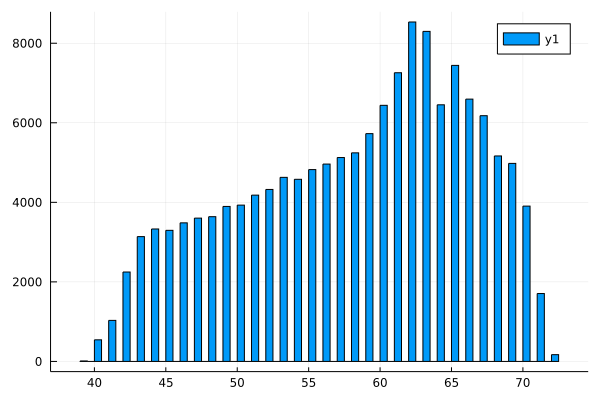

In [57]:
using Plots
histogram(phenotype_info_filtered.age_2010)

### BMI. 

In [58]:
mean(phenotype_info_filtered.BMI)

27.4897682541815

In [59]:
std(phenotype_info_filtered.BMI)

4.766336335945351

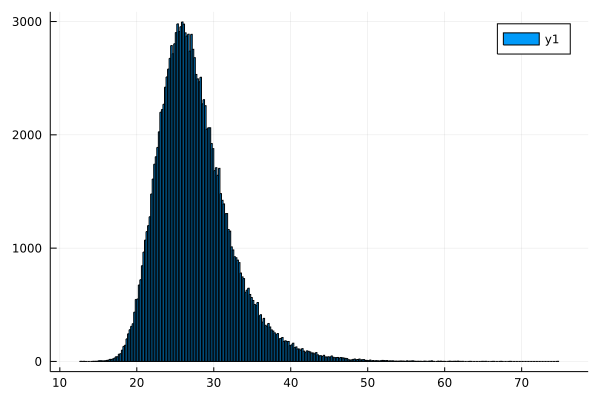

In [60]:
using Plots
histogram(phenotype_info_filtered.BMI)

## Split

Now we split the data into diabetic samples and nondiabetic samples. 

We have 13,193 diabetes patients remaining: 

In [112]:
bp_info_diabetics = filter(x -> diabetics_map[x.FID], bp_info_joined)

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,String,Int64,Float64,Float64,Int64?,String?
1,1000602,2004-03-30,3,174.0,97.0,1000602,NA
2,1000602,2004-08-04,3,141.0,80.0,1000602,NA
3,1000602,2004-08-13,3,161.0,79.0,1000602,NA
4,1000602,2004-08-20,3,157.0,98.0,1000602,NA
5,1000602,2004-08-27,3,180.0,105.0,1000602,NA
6,1000602,2004-09-03,3,161.0,95.0,1000602,NA
7,1000602,2004-09-14,3,137.0,93.0,1000602,NA
8,1000602,2004-09-24,3,180.0,110.0,1000602,NA
9,1000602,2004-09-30,3,146.0,90.0,1000602,NA


In [113]:
length(unique(bp_info_diabetics.FID))

13194

In [114]:
d = countmap(bp_info_diabetics.FID)
diabetic_measurements = []
for (k, v) in d
    push!(diabetic_measurements, v)
end

In [115]:
using Statistics

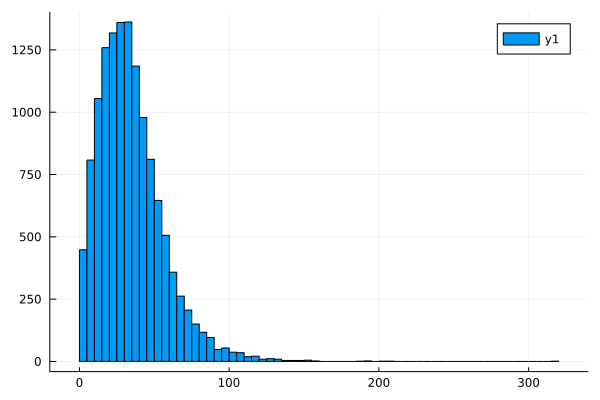

In [116]:
using Plots
histogram(diabetic_measurements)

In [117]:
CSV.write("bp_diabetics.csv", bp_info_diabetics)

"bp_diabetics.csv"

And we have 135,664 nondiabetic samples remaining. 

In [43]:
bp_info_nondiabetics = filter(x -> !diabetics_map[x.FID], bp_info_joined)

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,String,Int64,Float64,Float64,Int64?,String?
1,1000094,1997-10-22,3,120.0,70.0,1000094,0
2,1000094,2001-04-23,3,135.0,73.0,1000094,0
3,1000094,2001-10-03,3,128.0,70.0,1000094,0
4,1000094,2002-04-17,3,133.0,80.0,1000094,0
5,1000094,2003-02-12,3,129.0,80.0,1000094,0
6,1000094,2003-07-30,3,116.0,66.0,1000094,0
7,1000094,2006-08-14,3,130.0,78.0,1000094,0
8,1000094,2008-01-04,3,126.0,78.0,1000094,0
9,1000094,2008-07-18,3,120.0,64.0,1000094,0


In [44]:
length(unique(bp_info_nondiabetics.FID))

135676

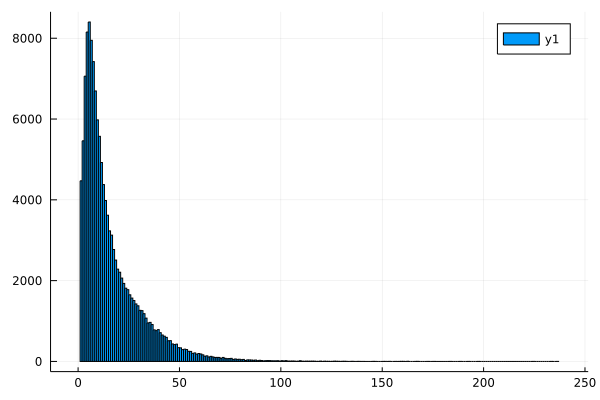

In [45]:
d = countmap(bp_info_nondiabetics.FID)
nondiabetic_measurements = []
for (k, v) in d
    push!(nondiabetic_measurements, v)
end
histogram(nondiabetic_measurements)

In [46]:
CSV.write("bp_nondiabetics.csv", bp_info_nondiabetics)

"bp_nondiabetics.csv"

In [ ]:
using CSV, DataFrames
df = CSV.read("bp_nondiabetics.csv", DataFrame)

,FID,event_dt,data_provider,Systolic_bp_pc,Diastolic_bp_pc,IID,AcIsch
,Int64,Date…,Int64,Float64,Float64,Int64,String
1,1000094,1997-10-22,3,120.0,70.0,1000094,0
2,1000094,2001-04-23,3,135.0,73.0,1000094,0
3,1000094,2001-10-03,3,128.0,70.0,1000094,0
4,1000094,2002-04-17,3,133.0,80.0,1000094,0
5,1000094,2003-02-12,3,129.0,80.0,1000094,0
6,1000094,2003-07-30,3,116.0,66.0,1000094,0
7,1000094,2006-08-14,3,130.0,78.0,1000094,0
8,1000094,2008-01-04,3,126.0,78.0,1000094,0
9,1000094,2008-07-18,3,120.0,64.0,1000094,0


In [ ]:
using StatsBase

In [ ]:
d = countmap(df.FID)
nondiabetic_measurements = []
for (k, v) in d
    if v > 200
        println(k)
    end
    push!(nondiabetic_measurements, v)
end
#histogram(nondiabetic_measurements)

2126090
4006379
3748162


In [ ]:
diabetic_samples = unique(bp_info_diabetics.FID);
nondiabetic_samples = unique(bp_info_nondiabetics.FID);

In [ ]:
io = open("diabetes_subjects_bp.txt", "w")
for v in diabetic_samples
    println(io, v)
end
close(io)

In [ ]:
io = open("nondiabetes_subjects_bp.txt", "w")
for v in nondiabetic_samples
    println(io, v)
end
close(io)

In [ ]:
length(nondiabetic_samples)

135676

In [ ]:
unique(bp_info_joined[!, :center])

22-element Array{Union{Missing, String},1}:
 "Newcastle"
 "Birmingham"
 "Sheffield"
 "Nottingham"
 "Hounslow"
 "Leeds"
 "Reading"
 "Edinburgh"
 "Cardiff"
 "Oxford"
 "Bristol"
 "Bury"
 "Middlesborough"
 "Glasgow"
 "Stoke"
 "Liverpool"
 "Swansea"
 "Croydon"
 "Manchester"
 "Wrexham"
 "Barts"
 "Stockport (pilot)"

In [ ]:
unique(data_center[!, :center])

22-element Array{String,1}:
 "Nottingham"
 "Bury"
 "Sheffield"
 "Glasgow"
 "Croydon"
 "Liverpool"
 "Leeds"
 "Reading"
 "Birmingham"
 "Swansea"
 "Cardiff"
 "Newcastle"
 "Middlesborough"
 "Bristol"
 "Hounslow"
 "Barts"
 "Edinburgh"
 "Stoke"
 "Oxford"
 "Manchester"
 "Stockport (pilot)"
 "Wrexham"

## Fitting the null model

Content of null_fitter_dbp_diabetes.jl: 

```julia
using DataFrames, CSV
using Statistics
using vGWAS
using Ipopt, WiSER
using LinearAlgebra
using KNITRO
using BGEN
# fit the null model
BLAS.set_num_threads(1)
solver = KNITRO.KnitroSolver(outlev=3) # outlev 0-6

genetic_iids_subsample = CSV.read("diabetes_subjects_bp.txt", DataFrame; header=false)[!, 1]


bp_data = CSV.read("bp_diabetics.csv", DataFrame)
genetic_iids_subsample = unique(bp_data.FID)
@time nm = vgwas(@formula(std_dbp ~ 1 + SEX + std_age + std_age_sq +
        PC1 + PC2 + PC3 + PC4 + PC5 + std_bmi),
    @formula(std_dbp ~ 1 + std_age),
    @formula(std_dbp ~ 1 + SEX + std_age + std_age_sq +
        PC1 + PC2 + PC3 + PC4 + PC5 +
        std_bmi),
    :IID,
    bp_data,
    nothing;
    nullfile="dbp.test.diabetics.null.txt",
    solver=solver,
    runs=10
)

println(nm)
using Serialization
open("fittednullmodel.dbp.test.diabetics.jls", "w") do io
    Serialization.serialize(io, nm)
end
```
- change `std_dbp` to `std_sbp` for analyzing sbp
- change `diabetes` or `diabetics` to `nondiabetics` or `nondiabetes` for analyzing non-diabetes participants
- Knitro is a commercial library installed on Hua's desktop. We decided to fit the null model only on Hua's machine, and when Aubrey needs to fit a null model, the data or the fitted null models will be shared through Box. 

## Running vGWAS on a cluster

The julia script for actual score test (scoretest_bp.jl) for a piece of BGEN file:

```julia
using DataFrames, CSV
using Statistics
using vGWAS
using WiSER
using LinearAlgebra
using BGEN
# fit the null model
BLAS.set_num_threads(1)


using Serialization

bgendir = ARGS[1] # ../ukb_imputed
chr = ARGS[2] # 1 to 22
fitted_null = ARGS[3] # "fittednullmodel.sbp.test.diabetics.jls"
pvalfile = ARGS[4] # "sbp.test.diabetics.chr$(chr).txt"
chunkidx = parse(Int, ARGS[5])
nchunks  = parse(Int, ARGS[6])

nm = open(deserialize, fitted_null)
genetic_iids_subsample = nm.ids

bgenfilename = bgendir * "/ukb_imp_chr$(chr)_v3"
samplefilename = bgendir * "/ukb48152_imp_chr$(chr)_v3_s487317.sample"
mfifilename = bgendir * "/ukb_mfi_chr$(chr)_v3.txt"
ukb_data = Bgen(bgenfilename * ".bgen"; sample_path = samplefilename)
genetic_iids = map(x -> parse(Int, split(x, " ")[1]), samples(ukb_data))

order_dict = Dict{Int, Int}()
for (i, iid) in enumerate(genetic_iids)
    order_dict[iid] = i
end

# sort!(bp_data, order(:IID, by=x -> order_dict[x]))

sample_indicator = falses(length(genetic_iids))
for v in genetic_iids_subsample
    sample_indicator[order_dict[v]] = true
end

# GWAS for each chromosome


min_maf = 0.002
min_info_score = 0.3
min_hwe_pval = 1e-10


mfi = CSV.read(mfifilename, DataFrame; header=false)
mfi.Column8 = map(x -> x == "NA" ? NaN : parse(Float64, x), mfi.Column8) # Column8: info score
snpmask = (mfi.Column6 .> min_maf) .& (mfi.Column8 .> 0.3) # Column6: MAF

chunksize = n_variants(ukb_data) ÷ nchunks + (n_variants(ukb_data) % nchunks > 0 ? 1 : 0)
startidx = chunksize * (chunkidx - 1) + 1
endidx = min(chunksize * chunkidx, n_variants(ukb_data))
snpmask = snpmask[startidx:endidx]

println("running for variants $startidx to $endidx")

# rearrange data in nm so that it matches bgen data
nullinds = indexin(genetic_iids[sample_indicator], nm.ids)
nm.obswts .= isempty(nm.obswts) ? nm.obswts : nm.obswts[nullinds]
nm.ids .= nm.ids[nullinds]
nm.nis .= nm.nis[nullinds]
nm.data .= nm.data[nullinds]
@assert genetic_iids[sample_indicator] == nm.ids "there is some issue -- sampleids not matching"
    
vgwas(nm, bgenfilename * ".bgen", count(sample_indicator);
    samplepath=samplefilename,
    pvalfile=pvalfile,
    snpinds=snpmask,
    min_hwe_pval = min_hwe_pval,
    bgenrowinds = sample_indicator,
    startidx = startidx,
    endidx = endidx,
    usespa=true)

```

- Command-line arguments
    - Argument 1: directory for the BGEN files. BGEN files (.bgen), BGEN index files (.bgen.bgi), and MFI files (.txt) should be included there.
    - Argument 2: chromosome
    - Argument 3: fitted null model (.jls)
    - Argument 4: path for the result p-value file
    - Argument 5: chunk index (1-based)
    - Argument 6: number of chunks
    
The code above runs the analysis on `ARGS[5]`-th slice out of `ARGS[6]` slices of chromosome `ARGS[2]`.

The following is the Hoffman2 jobscript using job array feature of Univa Grid Engine: (`sbp_diabetes.sh`)

```bash
#!/bin/bash
#$ -cwd
# error = Merged with joblog
#$ -o joblog.$JOB_ID.$TASK_ID
#$ -j y
#$ -pe shared 2
#$ -l h_rt=8:00:00,h_data=8G,arch=intel*
# Email address to notify
##$ -M $USER@mail
# Notify when
#$ -m a
#  Job array indexes
#$ -t 1-352:1

NCHUNKS=16
CHUNKIDX=$(( (${SGE_TASK_ID} - 1) % ${NCHUNKS} + 1 ))
CHR=$(( (${SGE_TASK_ID} - 1) / ${NCHUNKS} + 1))

PROJECTDIR=/u/home/k/kose/project-biostat-chair/bp/jobscripts
BGENDIR=/u/home/k/kose/project-biostat-chair/imputed
FITTED_NULL=/u/home/k/kose/project-biostat-chair/bp/fittednullmodel.sbp.test.diabetics.jls
PVALFILE=/u/home/k/kose/project-biostat-chair/bp/pvalfiles/sbp.test.diabetes.chr${CHR}.${CHUNKIDX}of${NCHUNKS}.txt

. /u/local/Modules/default/init/modules.sh
echo $CHUNKIDX
echo $CHR
echo $PVALFILE
module load julia/1.5.4
time julia --project=${PROJECTDIR} ${PROJECTDIR}/scoretest_bp.jl ${BGENDIR} ${CHR} ${FITTED_NULL} ${PVALFILE} ${CHUNKIDX} ${NCHUNKS}
```

The following is to rerun some of the jobs in case some of the jobs fail. 

```bash
#!/bin/bash
#$ -cwd
# error = Merged with joblog
#$ -o joblog.$JOB_ID.$TASK_ID
#$ -j y
#$ -pe shared 2
#$ -l h_rt=4:00:00,h_data=8G,arch=intel*
# Email address to notify
##$ -M $USER@mail
# Notify when
#$ -m a
#  Job array indexes (1 to number of jobs to run)
#$ -t 1-4:1

# an array of jobs to run again
TASK_IDS=(2 8 19 33)
# shell array indexing is 0-based
IDX=$(( ${SGE_TASK_ID} - 1 ))
TASK_ID=${TASK_IDS[IDX]}

NCHUNKS=16
CHUNKIDX=$(( (${TASK_ID} - 1) % ${NCHUNKS} + 1 ))
CHR=$(( (${TASK_ID} - 1) / ${NCHUNKS} + 1))

PROJECTDIR=/u/home/k/kose/project-biostat-chair/bp/jobscripts
BGENDIR="/u/home/k/kose/project-biostat-chair/imputed"
FITTED_NULL="/u/home/k/kose/project-biostat-chair/bp/fittednullmodel.dbp.run1.nondiabetics.jls"
PVALFILE=/u/home/k/kose/project-biostat-chair/bp/pvalfiles/dbp.run1.nondiabetes.chr${CHR}.${CHUNKIDX}of${NCHUNKS}.txt

echo $CHR
echo $CHUNKIDX
. /u/local/Modules/default/init/modules.sh
echo $PVALFILE
module load julia/1.5.4
time julia --project=${PROJECTDIR} ${PROJECTDIR}/scoretest_bp.jl ${BGENDIR} ${CHR} ${FITTED_NULL} ${PVALFILE} ${CHUNKIDX} ${NCHUNKS}
```

This scripts runs the analysis by splitting each chromosome into 16 slices. It can be modified by changing the number 352 in line 13 to 16 * (number_of_slices) and changing 16 in line 15 to (number_of_slices).  
The jobs should be submitted via
```sh
qsub sbp_diabetes.sh
```